**Library Import**

In [1]:
import os
import cv2
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets import register_coco_instances
import matplotlib.pyplot as plt
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.modeling import build_model, FastRCNNOutputLayers
import torch.nn as nn
import torch
from detectron2.modeling import ShapeSpec

**prepare the dataset**

In [2]:
import json

# Load both JSON files
with open("/home/gs285/AIPI_HW/Faster RCNN/individual_annotations_COCO/laptop_annotation.json") as f:
    data_1 = json.load(f)

with open("/home/gs285/AIPI_HW/Faster RCNN/individual_annotations_COCO/mouse_keyboard_annotation.json") as f:
    data_2 = json.load(f)
    
with open("/home/gs285/AIPI_HW/Faster RCNN/individual_annotations_COCO/utensil_annotation.json") as f:
    data_3 = json.load(f)

# Step 1: Define a consistent category mapping for both files
# We want both JSON files to follow this mapping:
category_mapping = {
    "laptop":1,
    "keyboard":2,
    "mouse":3,
    "utensil":4
}

# Step 2: Create a mapping of old category IDs to new ones
def create_id_transition_map(data, category_mapping):
    """Create a mapping from old category IDs to new category IDs."""
    id_transition = {}
    for category in data['categories']:
        if category['name'] in category_mapping:
            old_id = category['id']
            new_id = category_mapping[category['name']]
            id_transition[old_id] = new_id
    return id_transition


# Create transition maps for all datasets
id_map_1 = create_id_transition_map(data_1, category_mapping)
id_map_2 = create_id_transition_map(data_2, category_mapping)
id_map_3 = create_id_transition_map(data_3, category_mapping)

# Step 3: Apply the ID transition map to update annotations
def apply_id_transition(data, id_transition):
    """Update annotation category IDs using the provided ID transition map."""
    for annotation in data['annotations']:
        old_id = annotation['category_id']
        if old_id in id_transition:
            annotation['category_id'] = id_transition[old_id]
            
# Apply the transition maps to update annotations
apply_id_transition(data_1, id_map_1)
apply_id_transition(data_2, id_map_2)
apply_id_transition(data_3, id_map_3)            

# Step 4: Combine 'images' and 'annotations' from both datasets
combined_data = {
    "licenses": data_1.get('licenses', []),
    "info": data_1.get('info', {}),
    "categories": [{"id": id, "name": name} for name, id in category_mapping.items()],
    "images": data_1['images'] + data_2['images'] + data_3['images'],
    "annotations": data_1['annotations'] + data_2['annotations']+ data_3['annotations']
}

for cat in category_mapping:
    count = sum(1 for ann in combined_data['annotations'] if ann['category_id'] == category_mapping[cat])
    print(f"{cat}: {count} annotations")
    

# Step 4: Update image and annotation IDs to ensure uniqueness
def update_ids(data, image_offset, annotation_offset):
    """Update image and annotation IDs to ensure they are unique."""
    for img in data['images']:
        img['id'] += image_offset

    for ann in data['annotations']:
        ann['image_id'] += image_offset
        ann['id'] += annotation_offset

# Ensure unique IDs for images and annotations
image_id_offset  = max([img['id'] for img in combined_data['images']]) + 1
annotation_id_offset  = max([ann['id'] for ann in combined_data['annotations']]) + 1

# Update IDs for data_2 and data_3
update_ids(data_2, image_id_offset, annotation_id_offset)
update_ids(data_3, image_id_offset + len(data_2['images']), annotation_id_offset + len(data_2['annotations']))

# Step 5: Save the combined JSON file
with open("combined_annotations.json", "w") as f:
    json.dump(combined_data, f)

print("Combined JSON file created successfully!")

# Debugging: Print the number of annotations per category after update
print("Annotations per category after ID update:")
for cat_name, cat_id in category_mapping.items():
    count = sum(1 for ann in combined_data['annotations'] if ann['category_id'] == cat_id)
    print(f"{cat_name}: {count} annotations")


laptop: 102 annotations
keyboard: 126 annotations
mouse: 64 annotations
utensil: 467 annotations
Combined JSON file created successfully!
Annotations per category after ID update:
laptop: 102 annotations
keyboard: 126 annotations
mouse: 64 annotations
utensil: 467 annotations


In [3]:
import json
import os
from sklearn.model_selection import train_test_split

# Load the original COCO annotations JSON file
with open("/home/gs285/AIPI_HW/Faster RCNN/combined_annotations.json") as f:
    coco_data = json.load(f)

# Get all image IDs from the dataset
image_ids = [img['id'] for img in coco_data['images']]

# Split into 80% training and 20% validation
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

def filter_annotations_by_image_ids(coco_data, image_ids):
    # Filter images
    filtered_images = [img for img in coco_data['images'] if img['id'] in image_ids]
    
    # Filter annotations
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    
    # Preserve the other fields (categories, etc.)
    filtered_data = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": coco_data['categories']
    }
    return filtered_data

# Create new JSON files for train and val sets
train_data = filter_annotations_by_image_ids(coco_data, train_ids)
val_data = filter_annotations_by_image_ids(coco_data, val_ids)

# Save the new annotation files
os.makedirs("split_annotation", exist_ok=True)
with open("split_annotation/annotations_train.json", "w") as f:
    json.dump(train_data, f)

with open("split_annotation/annotations_val.json", "w") as f:
    json.dump(val_data, f)


**Visualization during the training phase on validation set**

In [9]:
import random
# Hook to evaluate and visualize the validation set every 100 iterations
class ValidationVisualizationHook(HookBase):
    def __init__(self, cfg, predictor, eval_period=500):
        self.cfg = cfg
        self.predictor = predictor
        self.eval_period = eval_period

    def after_step(self):
        iteration = self.trainer.iter
        if iteration % self.eval_period == 0 and iteration != 0:
            self.visualize_predictions()

    def visualize_predictions(self):
        # Get validation dataset
        dataset_dicts = DatasetCatalog.get(self.cfg.DATASETS.TEST[0])
        metadata = MetadataCatalog.get(self.cfg.DATASETS.TEST[0])

        # Randomly pick 5 images from the validation set
        random_images = random.sample(dataset_dicts, 5)
        
        # Visualize predictions on the first 5 validation images
        for d in random_images:
            img = cv2.imread(d["file_name"])
            outputs = self.predictor(img)
            
            # Print predictions to check if the model is producing results
            print("Predictions:", outputs)

            # Visualize the predicted bounding boxes
            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
            out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

            # Convert the visualized output to an image suitable for matplotlib
            result_image = out.get_image()[:, :, ::-1]

            # Display the image using matplotlib
            plt.figure(figsize=(12, 8))
            plt.imshow(result_image)
            plt.axis("off")  # Turn off axis
            plt.show()  # Display the image in the notebook


**Detector Training**

Training and evaluating with SCORE_THRESH_TEST=0.3
[10/22 18:03:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_f

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 18:03:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 18:03:33 d2.engine.train_loop]: Starting training from iteration 0


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:03:40 d2.utils.events]:  eta: 0:04:47  iter: 19  total_loss: 1.714  loss_cls: 1.47  loss_box_reg: 0.1545  loss_rpn_cls: 0.02087  loss_rpn_loc: 0.03646    time: 0.2916  last_time: 0.2925  data_time: 0.0482  last_data_time: 0.0057   lr: 9.5905e-05  max_mem: 0M
[10/22 18:03:46 d2.utils.events]:  eta: 0:04:47  iter: 39  total_loss: 0.6593  loss_cls: 0.3798  loss_box_reg: 0.1818  loss_rpn_cls: 0.02339  loss_rpn_loc: 0.02807    time: 0.3009  last_time: 0.3127  data_time: 0.0250  last_data_time: 0.0046   lr: 0.0001958  max_mem: 0M
[10/22 18:03:51 d2.utils.events]:  eta: 0:04:29  iter: 59  total_loss: 0.369  loss_cls: 0.1513  loss_box_reg: 0.1398  loss_rpn_cls: 0.01642  loss_rpn_loc: 0.02656    time: 0.2916  last_time: 0.2277  data_time: 0.0133  last_data_time: 0.0062   lr: 0.00029571  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:03:57 d2.utils.events]:  eta: 0:04:19  iter: 79  total_loss: 0.322  loss_cls: 0.148  loss_box_reg: 0.1473  loss_rpn_cls: 0.01078  loss_rpn_loc: 0.03868    time: 0.2857  last_time: 0.2588  data_time: 0.0070  last_data_time: 0.0024   lr: 0.0003956  max_mem: 0M
[10/22 18:04:02 d2.utils.events]:  eta: 0:04:15  iter: 99  total_loss: 0.3534  loss_cls: 0.1676  loss_box_reg: 0.1763  loss_rpn_cls: 0.007466  loss_rpn_loc: 0.01422    time: 0.2862  last_time: 0.2935  data_time: 0.0128  last_data_time: 0.0040   lr: 0.00049551  max_mem: 0M
[10/22 18:04:08 d2.utils.events]:  eta: 0:04:11  iter: 119  total_loss: 0.3558  loss_cls: 0.1478  loss_box_reg: 0.1481  loss_rpn_cls: 0.01228  loss_rpn_loc: 0.04312    time: 0.2873  last_time: 0.3039  data_time: 0.0235  last_data_time: 0.0055   lr: 0.00059541  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:04:14 d2.utils.events]:  eta: 0:04:06  iter: 139  total_loss: 0.3212  loss_cls: 0.1179  loss_box_reg: 0.1628  loss_rpn_cls: 0.01271  loss_rpn_loc: 0.02155    time: 0.2897  last_time: 0.3301  data_time: 0.0177  last_data_time: 0.0046   lr: 0.00069531  max_mem: 0M
[10/22 18:04:20 d2.utils.events]:  eta: 0:04:00  iter: 159  total_loss: 0.2876  loss_cls: 0.0985  loss_box_reg: 0.1423  loss_rpn_cls: 0.003861  loss_rpn_loc: 0.02803    time: 0.2884  last_time: 0.2311  data_time: 0.0102  last_data_time: 0.0011   lr: 0.00079521  max_mem: 0M
[10/22 18:04:26 d2.utils.events]:  eta: 0:03:54  iter: 179  total_loss: 0.3119  loss_cls: 0.1189  loss_box_reg: 0.1642  loss_rpn_cls: 0.01081  loss_rpn_loc: 0.01888    time: 0.2884  last_time: 0.2834  data_time: 0.0194  last_data_time: 0.0039   lr: 0.0008951  max_mem: 0M
[10/22 18:04:32 d2.utils.events]:  eta: 0:03:48  iter: 199  total_loss: 0.4058  loss_cls: 0.1586  loss_box_reg: 0.1939  loss_rpn_cls: 0.01033  loss_rpn_loc: 0.02115    time: 0.2883 

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:04:37 d2.utils.events]:  eta: 0:03:42  iter: 219  total_loss: 0.2874  loss_cls: 0.103  loss_box_reg: 0.1431  loss_rpn_cls: 0.0111  loss_rpn_loc: 0.02138    time: 0.2884  last_time: 0.3080  data_time: 0.0117  last_data_time: 0.0084   lr: 0.001  max_mem: 0M
[10/22 18:04:43 d2.utils.events]:  eta: 0:03:35  iter: 239  total_loss: 0.2926  loss_cls: 0.09955  loss_box_reg: 0.1567  loss_rpn_cls: 0.007509  loss_rpn_loc: 0.02359    time: 0.2872  last_time: 0.2427  data_time: 0.0138  last_data_time: 0.0052   lr: 0.001  max_mem: 0M
[10/22 18:04:49 d2.utils.events]:  eta: 0:03:30  iter: 259  total_loss: 0.2717  loss_cls: 0.08977  loss_box_reg: 0.1281  loss_rpn_cls: 0.009154  loss_rpn_loc: 0.04241    time: 0.2882  last_time: 0.3041  data_time: 0.0245  last_data_time: 0.0047   lr: 0.001  max_mem: 0M
[10/22 18:04:55 d2.utils.events]:  eta: 0:03:25  iter: 279  total_loss: 0.2813  loss_cls: 0.08696  loss_box_reg: 0.1467  loss_rpn_cls: 0.008026  loss_rpn_loc: 0.03865    time: 0.2886  last_time:

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:05:11 d2.utils.events]:  eta: 0:03:08  iter: 339  total_loss: 0.2429  loss_cls: 0.08159  loss_box_reg: 0.1224  loss_rpn_cls: 0.005566  loss_rpn_loc: 0.01742    time: 0.2867  last_time: 0.3193  data_time: 0.0119  last_data_time: 0.0026   lr: 0.001  max_mem: 0M
[10/22 18:05:17 d2.utils.events]:  eta: 0:03:02  iter: 359  total_loss: 0.1897  loss_cls: 0.06069  loss_box_reg: 0.08348  loss_rpn_cls: 0.006996  loss_rpn_loc: 0.01934    time: 0.2872  last_time: 0.3103  data_time: 0.0195  last_data_time: 0.0012   lr: 0.001  max_mem: 0M
[10/22 18:05:23 d2.utils.events]:  eta: 0:02:56  iter: 379  total_loss: 0.213  loss_cls: 0.06845  loss_box_reg: 0.1116  loss_rpn_cls: 0.005179  loss_rpn_loc: 0.02589    time: 0.2880  last_time: 0.2778  data_time: 0.0200  last_data_time: 0.0043   lr: 0.001  max_mem: 0M
[10/22 18:05:29 d2.utils.events]:  eta: 0:02:51  iter: 399  total_loss: 0.1853  loss_cls: 0.05953  loss_box_reg: 0.0857  loss_rpn_cls: 0.007185  loss_rpn_loc: 0.02068    time: 0.2878  last_t

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:05:35 d2.utils.events]:  eta: 0:02:45  iter: 419  total_loss: 0.1932  loss_cls: 0.07752  loss_box_reg: 0.09236  loss_rpn_cls: 0.01031  loss_rpn_loc: 0.02197    time: 0.2879  last_time: 0.3067  data_time: 0.0162  last_data_time: 0.0011   lr: 0.001  max_mem: 0M
[10/22 18:05:41 d2.utils.events]:  eta: 0:02:40  iter: 439  total_loss: 0.2448  loss_cls: 0.07758  loss_box_reg: 0.1108  loss_rpn_cls: 0.004222  loss_rpn_loc: 0.03179    time: 0.2883  last_time: 0.2473  data_time: 0.0120  last_data_time: 0.0014   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:05:47 d2.utils.events]:  eta: 0:02:34  iter: 459  total_loss: 0.1934  loss_cls: 0.07814  loss_box_reg: 0.08989  loss_rpn_cls: 0.002185  loss_rpn_loc: 0.03504    time: 0.2883  last_time: 0.2445  data_time: 0.0123  last_data_time: 0.0042   lr: 0.001  max_mem: 0M
[10/22 18:05:53 d2.utils.events]:  eta: 0:02:29  iter: 479  total_loss: 0.164  loss_cls: 0.04813  loss_box_reg: 0.07545  loss_rpn_cls: 0.002803  loss_rpn_loc: 0.01913    time: 0.2891  last_time: 0.3548  data_time: 0.0339  last_data_time: 0.0923   lr: 0.001  max_mem: 0M
[10/22 18:05:59 d2.utils.events]:  eta: 0:02:23  iter: 499  total_loss: 0.1716  loss_cls: 0.04943  loss_box_reg: 0.09286  loss_rpn_cls: 0.002225  loss_rpn_loc: 0.01936    time: 0.2890  last_time: 0.2480  data_time: 0.0199  last_data_time: 0.0014   lr: 0.001  max_mem: 0M
[10/22 18:05:59 d2.data.datasets.coco]: Loaded 60 images in COCO format from /home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json
Predictions: {'instances': Instances(num_

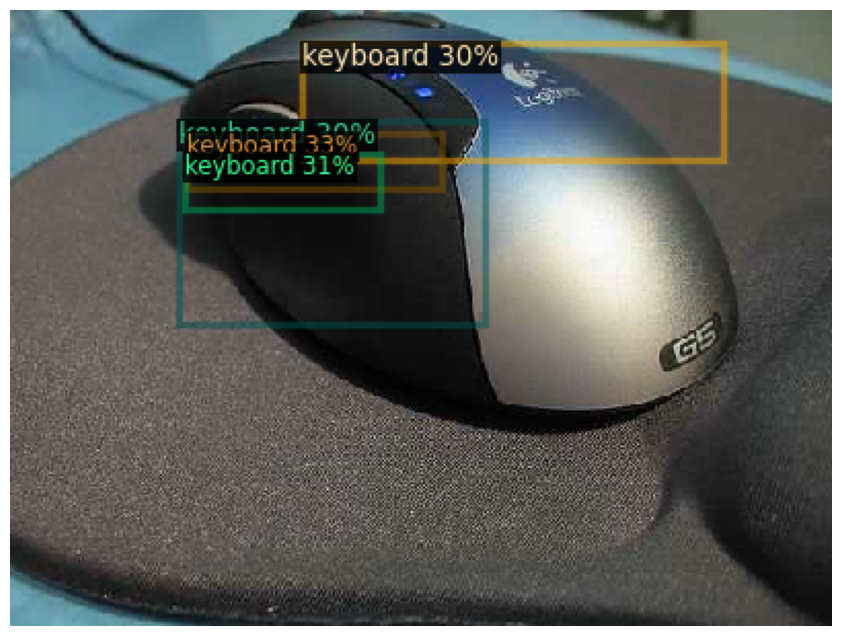

Predictions: {'instances': Instances(num_instances=5, image_height=1224, image_width=1632, fields=[pred_boxes: Boxes(tensor([[ 101.7105,  630.5479,  792.7270,  979.0722],
        [ 205.4908,  429.3308,  695.5687,  923.1201],
        [   0.0000,  649.5847,  937.8240, 1220.8708],
        [ 945.5385,  287.8666, 1149.9215,  331.0883],
        [  86.7365,  840.5553,  807.4184, 1188.9283]], device='cuda:4')), scores: tensor([0.3906, 0.3478, 0.3465, 0.3047, 0.3037], device='cuda:4'), pred_classes: tensor([1, 1, 1, 1, 1], device='cuda:4')])}


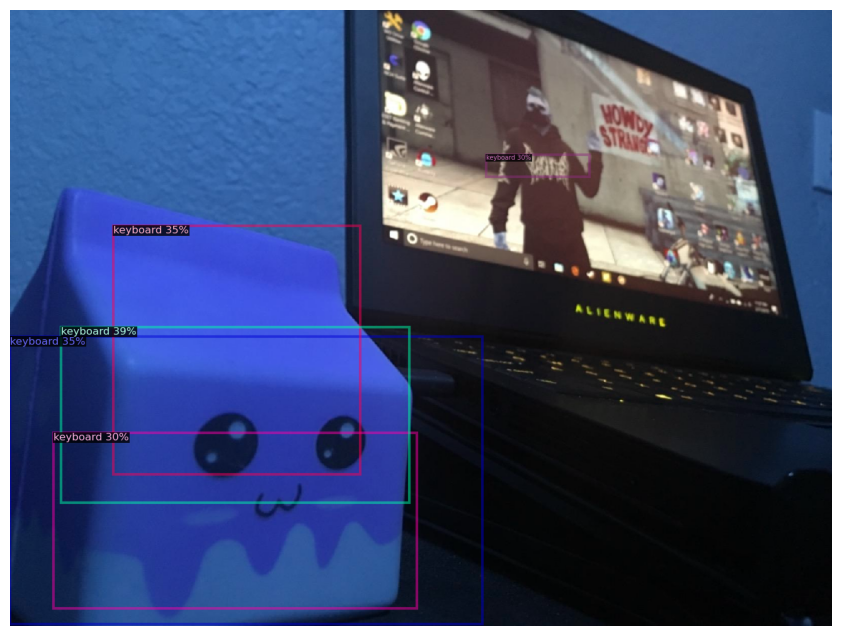

Predictions: {'instances': Instances(num_instances=5, image_height=375, image_width=500, fields=[pred_boxes: Boxes(tensor([[108.4204,   1.1617, 500.0000, 187.0552],
        [201.8513,  77.2198, 462.0491, 175.3814],
        [232.4341, 122.2575, 499.8702, 289.0170],
        [331.6074, 296.5310, 499.6407, 375.0000],
        [144.7576,  39.2036, 391.2498, 155.2041]], device='cuda:4')), scores: tensor([0.3187, 0.3070, 0.3064, 0.3024, 0.3018], device='cuda:4'), pred_classes: tensor([1, 1, 1, 1, 1], device='cuda:4')])}


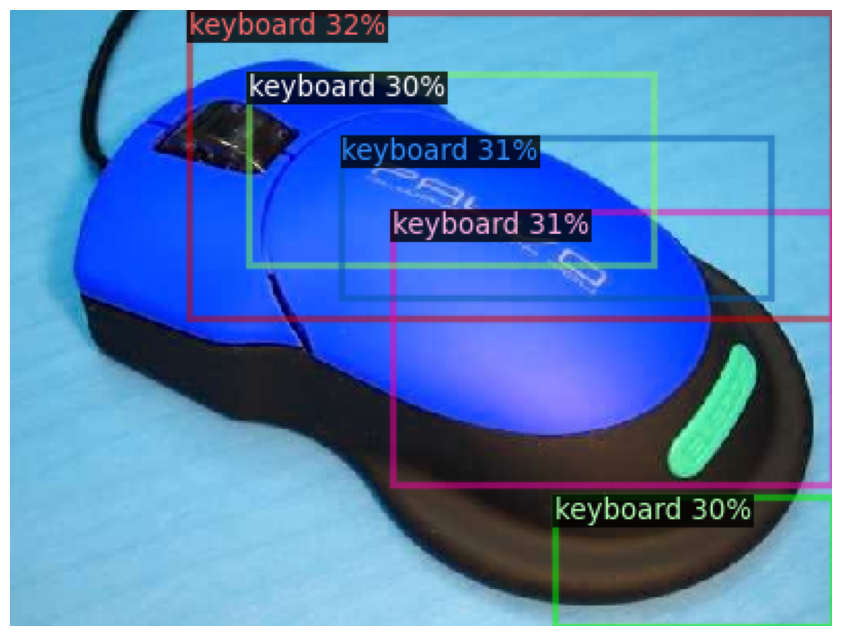

Predictions: {'instances': Instances(num_instances=5, image_height=1500, image_width=1500, fields=[pred_boxes: Boxes(tensor([[720.4125, 372.4308, 786.6431, 413.9283],
        [738.6470, 346.7501, 779.7684, 376.0316],
        [702.0607, 364.3285, 774.8849, 401.7245],
        [742.6865, 341.4954, 775.5001, 367.0124],
        [724.2769, 356.2290, 796.4973, 399.0897]], device='cuda:4')), scores: tensor([0.3472, 0.3183, 0.3167, 0.3022, 0.3014], device='cuda:4'), pred_classes: tensor([1, 1, 1, 1, 1], device='cuda:4')])}


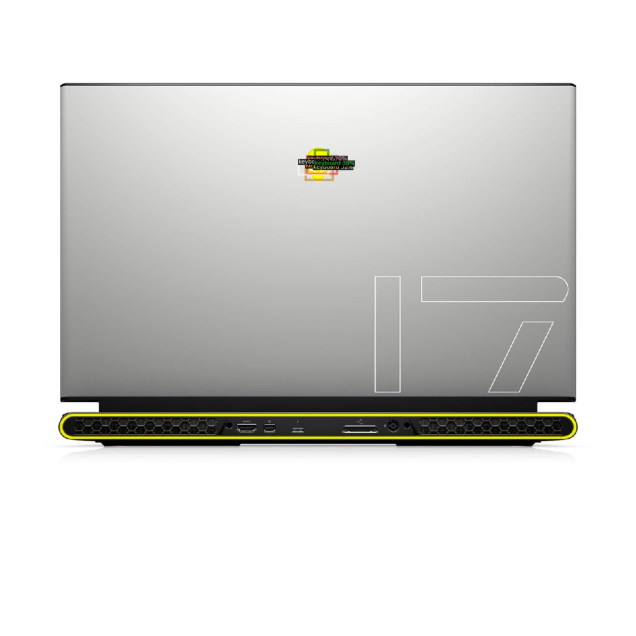

Predictions: {'instances': Instances(num_instances=3, image_height=2214, image_width=3420, fields=[pred_boxes: Boxes(tensor([[1282.7600, 1309.9401, 1615.3608, 1431.7672],
        [1900.7625,  473.1355, 1958.5353,  521.2974],
        [ 734.3577,  418.5463, 1162.4127,  844.6324]], device='cuda:4')), scores: tensor([0.3203, 0.3031, 0.3005], device='cuda:4'), pred_classes: tensor([1, 1, 1], device='cuda:4')])}


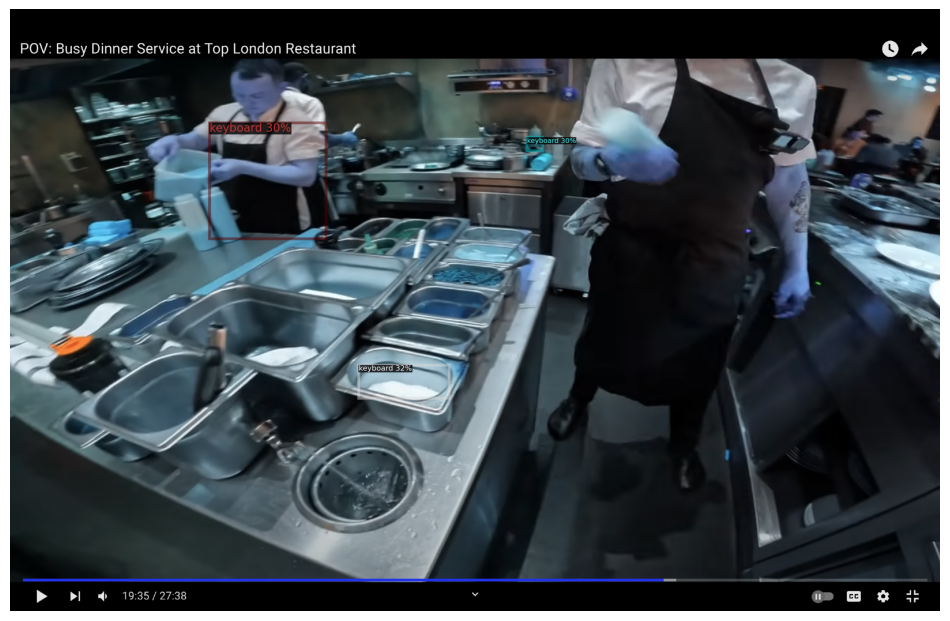

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:06:08 d2.utils.events]:  eta: 0:02:17  iter: 519  total_loss: 0.1924  loss_cls: 0.05369  loss_box_reg: 0.09086  loss_rpn_cls: 0.0023  loss_rpn_loc: 0.05412    time: 0.2886  last_time: 0.3073  data_time: 0.0104  last_data_time: 0.0009   lr: 0.001  max_mem: 0M
[10/22 18:06:13 d2.utils.events]:  eta: 0:02:11  iter: 539  total_loss: 0.1949  loss_cls: 0.05065  loss_box_reg: 0.08649  loss_rpn_cls: 0.003622  loss_rpn_loc: 0.02145    time: 0.2882  last_time: 0.2802  data_time: 0.0057  last_data_time: 0.0012   lr: 0.001  max_mem: 0M
[10/22 18:06:19 d2.utils.events]:  eta: 0:02:05  iter: 559  total_loss: 0.1825  loss_cls: 0.0661  loss_box_reg: 0.09398  loss_rpn_cls: 0.001773  loss_rpn_loc: 0.02761    time: 0.2881  last_time: 0.2482  data_time: 0.0165  last_data_time: 0.0034   lr: 0.001  max_mem: 0M
[10/22 18:06:25 d2.utils.events]:  eta: 0:02:00  iter: 579  total_loss: 0.1742  loss_cls: 0.0555  loss_box_reg: 0.05774  loss_rpn_cls: 0.005373  loss_rpn_loc: 0.02049    time: 0.2888  last_t

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:06:31 d2.utils.events]:  eta: 0:01:54  iter: 599  total_loss: 0.1553  loss_cls: 0.05586  loss_box_reg: 0.08193  loss_rpn_cls: 0.004032  loss_rpn_loc: 0.01332    time: 0.2891  last_time: 0.3366  data_time: 0.0158  last_data_time: 0.0255   lr: 0.001  max_mem: 0M
[10/22 18:06:37 d2.utils.events]:  eta: 0:01:48  iter: 619  total_loss: 0.2297  loss_cls: 0.07302  loss_box_reg: 0.1211  loss_rpn_cls: 0.00606  loss_rpn_loc: 0.02609    time: 0.2897  last_time: 0.4291  data_time: 0.0222  last_data_time: 0.1343   lr: 0.001  max_mem: 0M
[10/22 18:06:43 d2.utils.events]:  eta: 0:01:43  iter: 639  total_loss: 0.1488  loss_cls: 0.04568  loss_box_reg: 0.0689  loss_rpn_cls: 0.006411  loss_rpn_loc: 0.0202    time: 0.2895  last_time: 0.2946  data_time: 0.0135  last_data_time: 0.0036   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:06:49 d2.utils.events]:  eta: 0:01:37  iter: 659  total_loss: 0.1807  loss_cls: 0.05514  loss_box_reg: 0.07139  loss_rpn_cls: 0.002041  loss_rpn_loc: 0.02334    time: 0.2896  last_time: 0.2563  data_time: 0.0222  last_data_time: 0.0011   lr: 0.001  max_mem: 0M
[10/22 18:06:55 d2.utils.events]:  eta: 0:01:31  iter: 679  total_loss: 0.1741  loss_cls: 0.04709  loss_box_reg: 0.08314  loss_rpn_cls: 0.002612  loss_rpn_loc: 0.04741    time: 0.2897  last_time: 0.2619  data_time: 0.0218  last_data_time: 0.0014   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:07:00 d2.utils.events]:  eta: 0:01:26  iter: 699  total_loss: 0.09234  loss_cls: 0.03005  loss_box_reg: 0.04656  loss_rpn_cls: 0.001597  loss_rpn_loc: 0.01778    time: 0.2897  last_time: 0.3076  data_time: 0.0174  last_data_time: 0.0146   lr: 0.001  max_mem: 0M
[10/22 18:07:07 d2.utils.events]:  eta: 0:01:20  iter: 719  total_loss: 0.1272  loss_cls: 0.03849  loss_box_reg: 0.06569  loss_rpn_cls: 0.00226  loss_rpn_loc: 0.007278    time: 0.2900  last_time: 0.2939  data_time: 0.0238  last_data_time: 0.0010   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:07:12 d2.utils.events]:  eta: 0:01:14  iter: 739  total_loss: 0.175  loss_cls: 0.05509  loss_box_reg: 0.07145  loss_rpn_cls: 0.002868  loss_rpn_loc: 0.04001    time: 0.2902  last_time: 0.3048  data_time: 0.0210  last_data_time: 0.0045   lr: 0.001  max_mem: 0M
[10/22 18:07:18 d2.utils.events]:  eta: 0:01:08  iter: 759  total_loss: 0.1234  loss_cls: 0.03908  loss_box_reg: 0.06382  loss_rpn_cls: 0.00199  loss_rpn_loc: 0.01559    time: 0.2898  last_time: 0.2243  data_time: 0.0148  last_data_time: 0.0037   lr: 0.001  max_mem: 0M
[10/22 18:07:24 d2.utils.events]:  eta: 0:01:03  iter: 779  total_loss: 0.1323  loss_cls: 0.04191  loss_box_reg: 0.06656  loss_rpn_cls: 0.001697  loss_rpn_loc: 0.01433    time: 0.2898  last_time: 0.1979  data_time: 0.0216  last_data_time: 0.0013   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:07:30 d2.utils.events]:  eta: 0:00:57  iter: 799  total_loss: 0.1742  loss_cls: 0.05834  loss_box_reg: 0.06978  loss_rpn_cls: 0.002806  loss_rpn_loc: 0.03022    time: 0.2903  last_time: 0.3116  data_time: 0.0238  last_data_time: 0.0102   lr: 0.001  max_mem: 0M
[10/22 18:07:36 d2.utils.events]:  eta: 0:00:51  iter: 819  total_loss: 0.1236  loss_cls: 0.04524  loss_box_reg: 0.07247  loss_rpn_cls: 0.002588  loss_rpn_loc: 0.0232    time: 0.2903  last_time: 0.3146  data_time: 0.0181  last_data_time: 0.0109   lr: 0.001  max_mem: 0M
[10/22 18:07:42 d2.utils.events]:  eta: 0:00:45  iter: 839  total_loss: 0.1266  loss_cls: 0.03809  loss_box_reg: 0.06858  loss_rpn_cls: 0.0017  loss_rpn_loc: 0.01993    time: 0.2903  last_time: 0.3139  data_time: 0.0158  last_data_time: 0.0039   lr: 0.001  max_mem: 0M
[10/22 18:07:47 d2.utils.events]:  eta: 0:00:40  iter: 859  total_loss: 0.1719  loss_cls: 0.04707  loss_box_reg: 0.0872  loss_rpn_cls: 0.003221  loss_rpn_loc: 0.02056    time: 0.2903  last_t

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:07:53 d2.utils.events]:  eta: 0:00:34  iter: 879  total_loss: 0.1387  loss_cls: 0.03984  loss_box_reg: 0.08375  loss_rpn_cls: 0.004701  loss_rpn_loc: 0.02556    time: 0.2904  last_time: 0.2849  data_time: 0.0200  last_data_time: 0.0049   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:07:59 d2.utils.events]:  eta: 0:00:28  iter: 899  total_loss: 0.1166  loss_cls: 0.03143  loss_box_reg: 0.05643  loss_rpn_cls: 0.001762  loss_rpn_loc: 0.01772    time: 0.2901  last_time: 0.2929  data_time: 0.0151  last_data_time: 0.0049   lr: 0.001  max_mem: 0M
[10/22 18:08:05 d2.utils.events]:  eta: 0:00:22  iter: 919  total_loss: 0.139  loss_cls: 0.04347  loss_box_reg: 0.07392  loss_rpn_cls: 0.001765  loss_rpn_loc: 0.01638    time: 0.2901  last_time: 0.2880  data_time: 0.0059  last_data_time: 0.0040   lr: 0.001  max_mem: 0M
[10/22 18:08:11 d2.utils.events]:  eta: 0:00:17  iter: 939  total_loss: 0.1559  loss_cls: 0.04609  loss_box_reg: 0.06243  loss_rpn_cls: 0.001896  loss_rpn_loc: 0.02611    time: 0.2902  last_time: 0.3151  data_time: 0.0244  last_data_time: 0.0037   lr: 0.001  max_mem: 0M
[10/22 18:08:17 d2.utils.events]:  eta: 0:00:11  iter: 959  total_loss: 0.1755  loss_cls: 0.04856  loss_box_reg: 0.09578  loss_rpn_cls: 0.002915  loss_rpn_loc: 0.03177    time: 0.2903  las

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:08:22 d2.utils.events]:  eta: 0:00:05  iter: 979  total_loss: 0.09892  loss_cls: 0.02628  loss_box_reg: 0.05043  loss_rpn_cls: 0.002048  loss_rpn_loc: 0.02808    time: 0.2905  last_time: 0.2710  data_time: 0.0251  last_data_time: 0.0025   lr: 0.001  max_mem: 0M
[10/22 18:08:30 d2.utils.events]:  eta: 0:00:00  iter: 999  total_loss: 0.1606  loss_cls: 0.04701  loss_box_reg: 0.07985  loss_rpn_cls: 0.003416  loss_rpn_loc: 0.02045    time: 0.2908  last_time: 0.3710  data_time: 0.0274  last_data_time: 0.0645   lr: 0.001  max_mem: 0M
[10/22 18:08:30 d2.engine.hooks]: Overall training speed: 998 iterations in 0:04:50 (0.2908 s / it)
[10/22 18:08:30 d2.engine.hooks]: Total training time: 0:04:55 (0:00:05 on hooks)
[10/22 18:08:30 d2.data.datasets.coco]: Loaded 60 images in COCO format from /home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json
[10/22 18:08:30 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #in

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 18:08:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 18:08:44 d2.engine.train_loop]: Starting training from iteration 0


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:08:50 d2.utils.events]:  eta: 0:04:34  iter: 19  total_loss: 1.769  loss_cls: 1.482  loss_box_reg: 0.1731  loss_rpn_cls: 0.02264  loss_rpn_loc: 0.03774    time: 0.2930  last_time: 0.4713  data_time: 0.0531  last_data_time: 0.1466   lr: 9.5905e-05  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:08:56 d2.utils.events]:  eta: 0:04:32  iter: 39  total_loss: 0.5531  loss_cls: 0.3239  loss_box_reg: 0.1412  loss_rpn_cls: 0.01379  loss_rpn_loc: 0.01629    time: 0.2930  last_time: 0.4165  data_time: 0.0198  last_data_time: 0.1307   lr: 0.0001958  max_mem: 0M
[10/22 18:09:02 d2.utils.events]:  eta: 0:04:29  iter: 59  total_loss: 0.3413  loss_cls: 0.1769  loss_box_reg: 0.1344  loss_rpn_cls: 0.01357  loss_rpn_loc: 0.02279    time: 0.2970  last_time: 0.3091  data_time: 0.0320  last_data_time: 0.1215   lr: 0.00029571  max_mem: 0M
[10/22 18:09:08 d2.utils.events]:  eta: 0:04:24  iter: 79  total_loss: 0.3324  loss_cls: 0.1498  loss_box_reg: 0.1353  loss_rpn_cls: 0.01327  loss_rpn_loc: 0.01849    time: 0.2955  last_time: 0.2855  data_time: 0.0137  last_data_time: 0.0051   lr: 0.0003956  max_mem: 0M
[10/22 18:09:14 d2.utils.events]:  eta: 0:04:19  iter: 99  total_loss: 0.3349  loss_cls: 0.1376  loss_box_reg: 0.1251  loss_rpn_cls: 0.01285  loss_rpn_loc: 0.03685    time: 0.2959  last_

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:09:32 d2.utils.events]:  eta: 0:04:00  iter: 159  total_loss: 0.326  loss_cls: 0.1267  loss_box_reg: 0.1609  loss_rpn_cls: 0.01083  loss_rpn_loc: 0.01646    time: 0.2973  last_time: 0.3643  data_time: 0.0171  last_data_time: 0.0642   lr: 0.00079521  max_mem: 0M
[10/22 18:09:38 d2.utils.events]:  eta: 0:03:55  iter: 179  total_loss: 0.3696  loss_cls: 0.1292  loss_box_reg: 0.1804  loss_rpn_cls: 0.01484  loss_rpn_loc: 0.03612    time: 0.2962  last_time: 0.3159  data_time: 0.0219  last_data_time: 0.0050   lr: 0.0008951  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:09:44 d2.utils.events]:  eta: 0:03:49  iter: 199  total_loss: 0.3126  loss_cls: 0.1038  loss_box_reg: 0.1524  loss_rpn_cls: 0.006616  loss_rpn_loc: 0.03435    time: 0.2961  last_time: 0.3124  data_time: 0.0260  last_data_time: 0.0011   lr: 0.000995  max_mem: 0M
[10/22 18:09:50 d2.utils.events]:  eta: 0:03:44  iter: 219  total_loss: 0.2651  loss_cls: 0.08188  loss_box_reg: 0.1411  loss_rpn_cls: 0.003463  loss_rpn_loc: 0.02584    time: 0.2981  last_time: 0.2810  data_time: 0.0268  last_data_time: 0.0012   lr: 0.001  max_mem: 0M
[10/22 18:09:56 d2.utils.events]:  eta: 0:03:38  iter: 239  total_loss: 0.2774  loss_cls: 0.09663  loss_box_reg: 0.1547  loss_rpn_cls: 0.009555  loss_rpn_loc: 0.02803    time: 0.2974  last_time: 0.2486  data_time: 0.0223  last_data_time: 0.0105   lr: 0.001  max_mem: 0M
[10/22 18:10:02 d2.utils.events]:  eta: 0:03:32  iter: 259  total_loss: 0.2869  loss_cls: 0.08334  loss_box_reg: 0.1462  loss_rpn_cls: 0.009861  loss_rpn_loc: 0.02573    time: 0.2971  last

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:10:14 d2.utils.events]:  eta: 0:03:21  iter: 299  total_loss: 0.2973  loss_cls: 0.09423  loss_box_reg: 0.1844  loss_rpn_cls: 0.005366  loss_rpn_loc: 0.01524    time: 0.2970  last_time: 0.2955  data_time: 0.0193  last_data_time: 0.0047   lr: 0.001  max_mem: 0M
[10/22 18:10:20 d2.utils.events]:  eta: 0:03:15  iter: 319  total_loss: 0.2651  loss_cls: 0.06946  loss_box_reg: 0.1248  loss_rpn_cls: 0.008172  loss_rpn_loc: 0.02981    time: 0.2972  last_time: 0.3082  data_time: 0.0263  last_data_time: 0.0061   lr: 0.001  max_mem: 0M
[10/22 18:10:25 d2.utils.events]:  eta: 0:03:10  iter: 339  total_loss: 0.2382  loss_cls: 0.07669  loss_box_reg: 0.1115  loss_rpn_cls: 0.009016  loss_rpn_loc: 0.03284    time: 0.2969  last_time: 0.3014  data_time: 0.0111  last_data_time: 0.0101   lr: 0.001  max_mem: 0M
[10/22 18:10:31 d2.utils.events]:  eta: 0:03:04  iter: 359  total_loss: 0.2049  loss_cls: 0.072  loss_box_reg: 0.09451  loss_rpn_cls: 0.006062  loss_rpn_loc: 0.02972    time: 0.2964  last_ti

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:10:55 d2.utils.events]:  eta: 0:02:42  iter: 439  total_loss: 0.2359  loss_cls: 0.07001  loss_box_reg: 0.1166  loss_rpn_cls: 0.0009604  loss_rpn_loc: 0.02196    time: 0.2964  last_time: 0.3099  data_time: 0.0220  last_data_time: 0.0025   lr: 0.001  max_mem: 0M
[10/22 18:11:01 d2.utils.events]:  eta: 0:02:35  iter: 459  total_loss: 0.2077  loss_cls: 0.06491  loss_box_reg: 0.09567  loss_rpn_cls: 0.002933  loss_rpn_loc: 0.02801    time: 0.2962  last_time: 0.3320  data_time: 0.0176  last_data_time: 0.0662   lr: 0.001  max_mem: 0M
[10/22 18:11:07 d2.utils.events]:  eta: 0:02:30  iter: 479  total_loss: 0.2868  loss_cls: 0.1113  loss_box_reg: 0.1263  loss_rpn_cls: 0.004728  loss_rpn_loc: 0.02939    time: 0.2958  last_time: 0.3062  data_time: 0.0088  last_data_time: 0.0061   lr: 0.001  max_mem: 0M
[10/22 18:11:13 d2.utils.events]:  eta: 0:02:24  iter: 499  total_loss: 0.1949  loss_cls: 0.07383  loss_box_reg: 0.08603  loss_rpn_cls: 0.004584  loss_rpn_loc: 0.02011    time: 0.2959  last

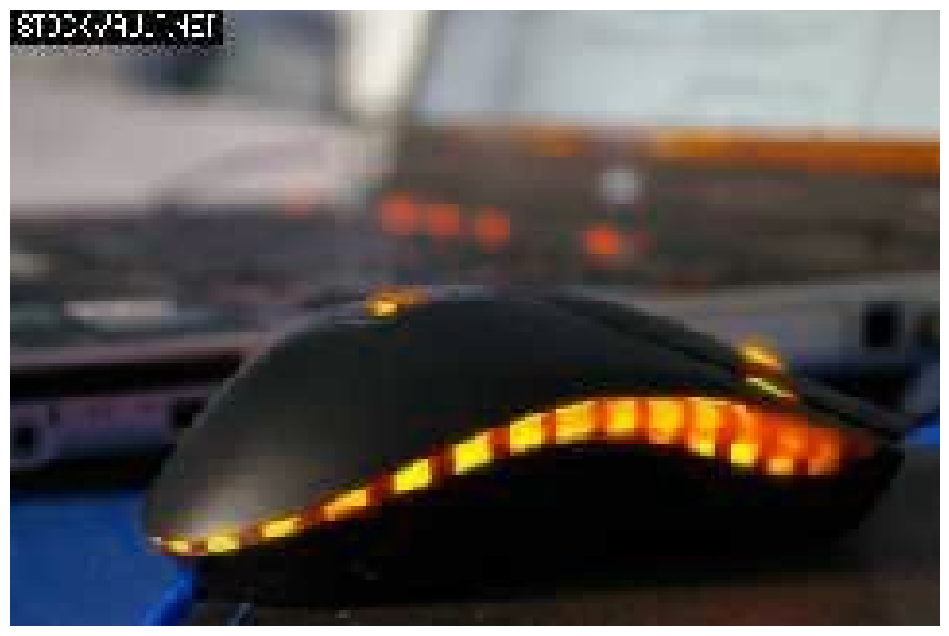

Predictions: {'instances': Instances(num_instances=0, image_height=359, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:4', size=(0, 4))), scores: tensor([], device='cuda:4'), pred_classes: tensor([], device='cuda:4', dtype=torch.int64)])}


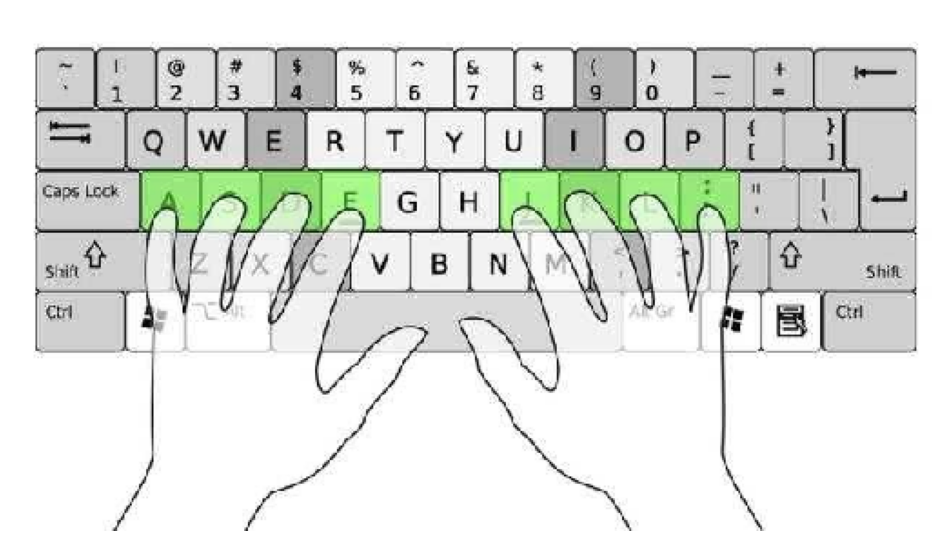

Predictions: {'instances': Instances(num_instances=0, image_height=800, image_width=600, fields=[pred_boxes: Boxes(tensor([], device='cuda:4', size=(0, 4))), scores: tensor([], device='cuda:4'), pred_classes: tensor([], device='cuda:4', dtype=torch.int64)])}


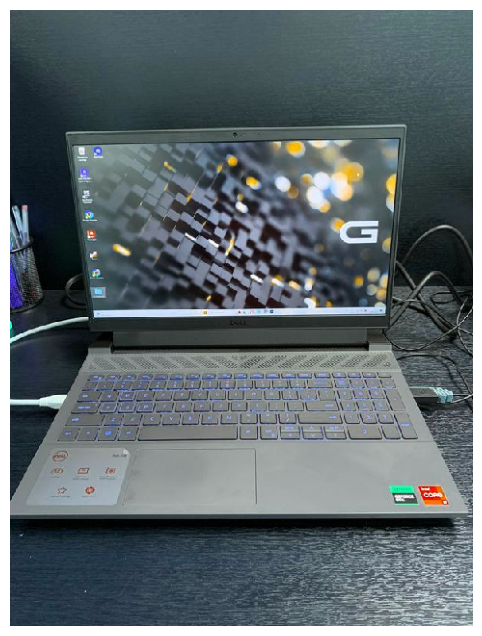

Predictions: {'instances': Instances(num_instances=0, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:4', size=(0, 4))), scores: tensor([], device='cuda:4'), pred_classes: tensor([], device='cuda:4', dtype=torch.int64)])}


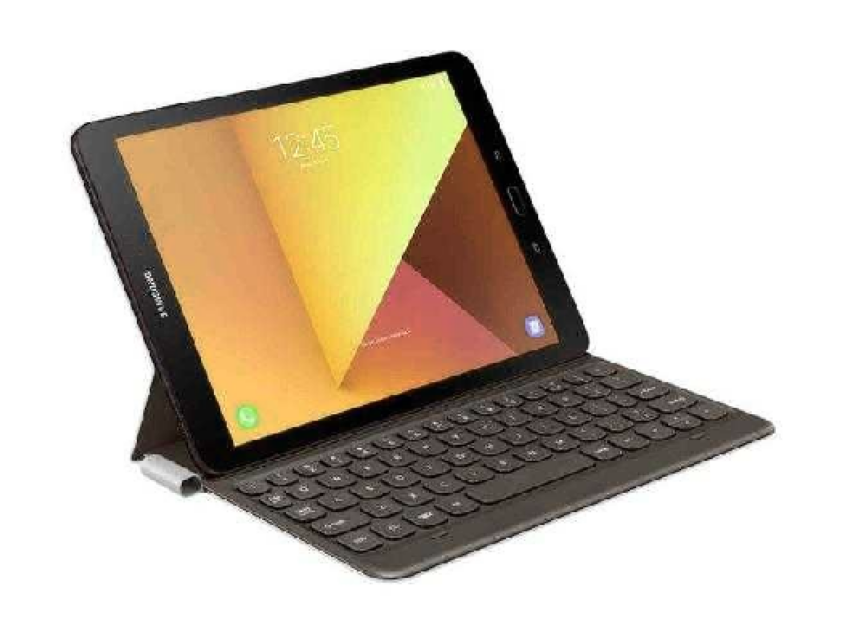

Predictions: {'instances': Instances(num_instances=0, image_height=2214, image_width=3420, fields=[pred_boxes: Boxes(tensor([], device='cuda:4', size=(0, 4))), scores: tensor([], device='cuda:4'), pred_classes: tensor([], device='cuda:4', dtype=torch.int64)])}


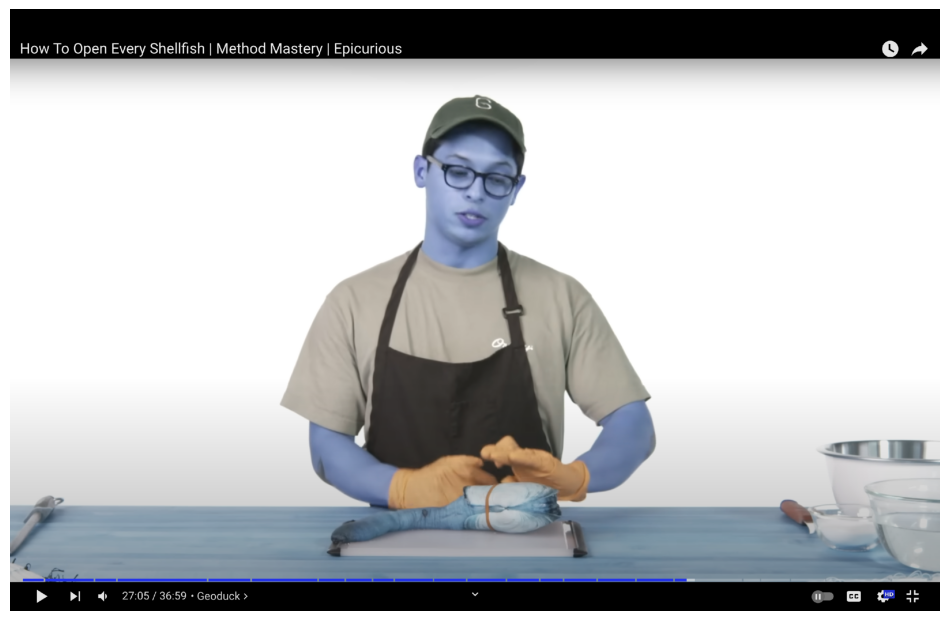

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:11:21 d2.utils.events]:  eta: 0:02:18  iter: 519  total_loss: 0.1668  loss_cls: 0.05638  loss_box_reg: 0.08659  loss_rpn_cls: 0.005218  loss_rpn_loc: 0.02338    time: 0.2962  last_time: 0.2824  data_time: 0.0240  last_data_time: 0.0383   lr: 0.001  max_mem: 0M
[10/22 18:11:27 d2.utils.events]:  eta: 0:02:12  iter: 539  total_loss: 0.2266  loss_cls: 0.06673  loss_box_reg: 0.1062  loss_rpn_cls: 0.008744  loss_rpn_loc: 0.03172    time: 0.2962  last_time: 0.2900  data_time: 0.0317  last_data_time: 0.0044   lr: 0.001  max_mem: 0M
[10/22 18:11:33 d2.utils.events]:  eta: 0:02:07  iter: 559  total_loss: 0.1461  loss_cls: 0.04132  loss_box_reg: 0.0654  loss_rpn_cls: 0.002442  loss_rpn_loc: 0.02652    time: 0.2964  last_time: 0.2978  data_time: 0.0162  last_data_time: 0.0040   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:11:39 d2.utils.events]:  eta: 0:02:01  iter: 579  total_loss: 0.1517  loss_cls: 0.0478  loss_box_reg: 0.08542  loss_rpn_cls: 0.00177  loss_rpn_loc: 0.01242    time: 0.2964  last_time: 0.2708  data_time: 0.0217  last_data_time: 0.0015   lr: 0.001  max_mem: 0M
[10/22 18:11:45 d2.utils.events]:  eta: 0:01:55  iter: 599  total_loss: 0.2172  loss_cls: 0.06806  loss_box_reg: 0.103  loss_rpn_cls: 0.004196  loss_rpn_loc: 0.0376    time: 0.2965  last_time: 0.2296  data_time: 0.0200  last_data_time: 0.0449   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:11:51 d2.utils.events]:  eta: 0:01:50  iter: 619  total_loss: 0.1667  loss_cls: 0.03455  loss_box_reg: 0.05635  loss_rpn_cls: 0.0009463  loss_rpn_loc: 0.01783    time: 0.2960  last_time: 0.2602  data_time: 0.0048  last_data_time: 0.0042   lr: 0.001  max_mem: 0M
[10/22 18:11:57 d2.utils.events]:  eta: 0:01:43  iter: 639  total_loss: 0.1811  loss_cls: 0.05081  loss_box_reg: 0.07493  loss_rpn_cls: 0.005691  loss_rpn_loc: 0.03463    time: 0.2959  last_time: 0.2822  data_time: 0.0192  last_data_time: 0.0049   lr: 0.001  max_mem: 0M
[10/22 18:12:02 d2.utils.events]:  eta: 0:01:38  iter: 659  total_loss: 0.1616  loss_cls: 0.05213  loss_box_reg: 0.07702  loss_rpn_cls: 0.001695  loss_rpn_loc: 0.01933    time: 0.2956  last_time: 0.2483  data_time: 0.0155  last_data_time: 0.0037   lr: 0.001  max_mem: 0M
[10/22 18:12:08 d2.utils.events]:  eta: 0:01:32  iter: 679  total_loss: 0.2104  loss_cls: 0.06402  loss_box_reg: 0.09293  loss_rpn_cls: 0.004591  loss_rpn_loc: 0.03983    time: 0.2959  l

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:12:14 d2.utils.events]:  eta: 0:01:26  iter: 699  total_loss: 0.1702  loss_cls: 0.04938  loss_box_reg: 0.0767  loss_rpn_cls: 0.00217  loss_rpn_loc: 0.03012    time: 0.2955  last_time: 0.2290  data_time: 0.0146  last_data_time: 0.0027   lr: 0.001  max_mem: 0M
[10/22 18:12:20 d2.utils.events]:  eta: 0:01:20  iter: 719  total_loss: 0.1537  loss_cls: 0.05688  loss_box_reg: 0.08594  loss_rpn_cls: 0.003128  loss_rpn_loc: 0.02075    time: 0.2953  last_time: 0.2319  data_time: 0.0229  last_data_time: 0.0046   lr: 0.001  max_mem: 0M
[10/22 18:12:26 d2.utils.events]:  eta: 0:01:14  iter: 739  total_loss: 0.1621  loss_cls: 0.04632  loss_box_reg: 0.07537  loss_rpn_cls: 0.003193  loss_rpn_loc: 0.01456    time: 0.2951  last_time: 0.3443  data_time: 0.0210  last_data_time: 0.0383   lr: 0.001  max_mem: 0M
[10/22 18:12:32 d2.utils.events]:  eta: 0:01:09  iter: 759  total_loss: 0.1546  loss_cls: 0.05301  loss_box_reg: 0.06372  loss_rpn_cls: 0.003157  loss_rpn_loc: 0.02258    time: 0.2953  last

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:12:49 d2.utils.events]:  eta: 0:00:51  iter: 819  total_loss: 0.1508  loss_cls: 0.04089  loss_box_reg: 0.07034  loss_rpn_cls: 0.005046  loss_rpn_loc: 0.02855    time: 0.2951  last_time: 0.3061  data_time: 0.0303  last_data_time: 0.0055   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:12:55 d2.utils.events]:  eta: 0:00:46  iter: 839  total_loss: 0.1577  loss_cls: 0.04727  loss_box_reg: 0.07075  loss_rpn_cls: 0.001149  loss_rpn_loc: 0.022    time: 0.2954  last_time: 0.3194  data_time: 0.0274  last_data_time: 0.0536   lr: 0.001  max_mem: 0M
[10/22 18:13:02 d2.utils.events]:  eta: 0:00:40  iter: 859  total_loss: 0.1451  loss_cls: 0.04594  loss_box_reg: 0.07428  loss_rpn_cls: 0.001875  loss_rpn_loc: 0.01777    time: 0.2956  last_time: 0.2613  data_time: 0.0346  last_data_time: 0.0014   lr: 0.001  max_mem: 0M
[10/22 18:13:07 d2.utils.events]:  eta: 0:00:34  iter: 879  total_loss: 0.1661  loss_cls: 0.0516  loss_box_reg: 0.08303  loss_rpn_cls: 0.003745  loss_rpn_loc: 0.02507    time: 0.2954  last_time: 0.2342  data_time: 0.0160  last_data_time: 0.0050   lr: 0.001  max_mem: 0M
[10/22 18:13:13 d2.utils.events]:  eta: 0:00:28  iter: 899  total_loss: 0.1201  loss_cls: 0.03257  loss_box_reg: 0.05041  loss_rpn_cls: 0.0009949  loss_rpn_loc: 0.0135    time: 0.2955  last_

/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:13:19 d2.utils.events]:  eta: 0:00:23  iter: 919  total_loss: 0.1547  loss_cls: 0.04597  loss_box_reg: 0.08494  loss_rpn_cls: 0.004537  loss_rpn_loc: 0.0234    time: 0.2956  last_time: 0.2849  data_time: 0.0217  last_data_time: 0.0013   lr: 0.001  max_mem: 0M
[10/22 18:13:25 d2.utils.events]:  eta: 0:00:17  iter: 939  total_loss: 0.1446  loss_cls: 0.04922  loss_box_reg: 0.07826  loss_rpn_cls: 0.001588  loss_rpn_loc: 0.0266    time: 0.2958  last_time: 0.2442  data_time: 0.0225  last_data_time: 0.0050   lr: 0.001  max_mem: 0M


/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/22 18:13:31 d2.utils.events]:  eta: 0:00:11  iter: 959  total_loss: 0.1057  loss_cls: 0.03407  loss_box_reg: 0.04669  loss_rpn_cls: 0.0007904  loss_rpn_loc: 0.02209    time: 0.2955  last_time: 0.2632  data_time: 0.0213  last_data_time: 0.0065   lr: 0.001  max_mem: 0M
[10/22 18:13:37 d2.engine.hooks]: Overall training speed: 977 iterations in 0:04:48 (0.2956 s / it)
[10/22 18:13:37 d2.engine.hooks]: Total training time: 0:04:51 (0:00:02 on hooks)
[10/22 18:13:37 d2.utils.events]:  eta: 0:00:05  iter: 979  total_loss: 0.1353  loss_cls: 0.04368  loss_box_reg: 0.07139  loss_rpn_cls: 0.002038  loss_rpn_loc: 0.02401    time: 0.2954  last_time: 0.2876  data_time: 0.0122  last_data_time: 0.0050   lr: 0.001  max_mem: 0M


KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt

class Detector:
    def __init__(self, score_thresh_test=0.5):
        # Register datasets
        register_coco_instances("my_dataset_train", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_train.json", "/home/gs285/AIPI_HW/image_dataset")
        register_coco_instances("my_dataset_val", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json", "/home/gs285/AIPI_HW/image_dataset")

        # Create configuration
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
        self.cfg.DATASETS.TRAIN = ("my_dataset_train",)
        self.cfg.DATASETS.TEST = ("my_dataset_val",)
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh_test
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
        self.cfg.MODEL.DEVICE = 'cuda:4'
        self.cfg.SOLVER.MAX_ITER = 1000
        self.cfg.SOLVER.IMS_PER_BATCH = 2
        self.cfg.SOLVER.BASE_LR = 0.001
        self.cfg.SOLVER.WARMUP_ITERS = 200
        self.cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
        self.cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
        self.cfg.OUTPUT_DIR = "./output"

        # Create trainer and predictor
        self.trainer = CustomTrainer(self.cfg)
        self.predictor = DefaultPredictor(self.cfg)

        # Add custom hooks (visualize predictions every 100 iterations)
        self.trainer.register_hooks([ValidationVisualizationHook(self.cfg, self.predictor, eval_period=499)])

    def train(self):
        # Resume or start training
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()

    def evaluate(self):
        val_results = self.trainer.test(self.cfg, self.trainer.model)
        return val_results['bbox']['AP']

# Loop over different SCORE_THRESH_TEST values and store mAP results
thresh_values = [0.2, 0.3, 0.4, 0.5]
map_results = []

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# # Instantiate and run the detector
# detector = Detector()
# detector.train()
# detector.evaluate()
for thresh in thresh_values:
    print(f"Training and evaluating with SCORE_THRESH_TEST={thresh}")
    detector = Detector(score_thresh_test=thresh)
    detector.train()
    mAP = detector.evaluate()
    map_results.append(mAP)
    
# Visualize the results
plt.figure(figsize=(10, 5))
plt.plot(thresh_values, map_results, marker='o')
plt.xlabel('SCORE_THRESH_TEST')
plt.ylabel('mAP')
plt.title('Effect of SCORE_THRESH_TEST on mAP after 1000 Epochs')
plt.grid(True)
plt.show()

In [7]:
from detectron2.modeling.box_regression import Box2BoxTransform
class Detector:
    def __init__(self):
        # Register datasets
        register_coco_instances("my_dataset_train", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_train.json", "/home/gs285/AIPI_HW/image_dataset")
        register_coco_instances("my_dataset_val", {}, "/home/gs285/AIPI_HW/Faster RCNN/split_annotation/annotations_val.json", "/home/gs285/AIPI_HW/image_dataset")

        # Create configuration
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
        self.cfg.DATASETS.TRAIN = ("my_dataset_train",)
        self.cfg.DATASETS.TEST = ("my_dataset_val",)
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
        self.cfg.MODEL.DEVICE = 'cuda:4'
        self.cfg.SOLVER.MAX_ITER = 1000
        self.cfg.SOLVER.IMS_PER_BATCH = 2
        self.cfg.SOLVER.BASE_LR = 0.001
        self.cfg.SOLVER.WARMUP_ITERS = 200
        self.cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
        self.cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
        self.cfg.SOLVER.CLIP_GRADIENTS.TYPE = "norm"
        self.cfg.OUTPUT_DIR = "./output"

        # Build the model and reset the box predictor
        self.model = build_model(self.cfg)
        self.reset_box_predictor()
        self.model.to(self.cfg.MODEL.DEVICE)
        
        # Create trainer and predictor
        self.trainer = CustomTrainer(self.cfg)
        self.trainer.model = self.model
        self.predictor = DefaultPredictor(self.cfg)

        # Add custom hooks (visualize predictions every 100 iterations)
        self.trainer.register_hooks([ValidationVisualizationHook(self.cfg, self.predictor, eval_period=500)])


    def reset_box_predictor(self):
        """Reset the ROI box predictor to match the number of classes."""
        # Reinitialize the predictor to have the correct number of output classes
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # self.model.roi_heads.box_predictor = nn.Sequential(
        #     nn.Linear(in_features, self.cfg.MODEL.ROI_HEADS.NUM_CLASSES + 1),  # outputs logits for each class, including one extra class for the background
        #     nn.Linear(in_features, (self.cfg.MODEL.ROI_HEADS.NUM_CLASSES) * 4)  # bounding box regression, meaning it refines the coordinates of the predicted bounding boxes.
        # )
        # Define the input shape for the new box predictor
        input_shape = ShapeSpec(channels=in_features)
        box2box_transform = Box2BoxTransform(weights=(10.0, 10.0, 5.0, 5.0))
        
        
        self.model.roi_heads.box_predictor = FastRCNNOutputLayers(
            input_shape=input_shape,
            box2box_transform=box2box_transform,
            num_classes=self.cfg.MODEL.ROI_HEADS.NUM_CLASSES + 1,  # +1 for background
            test_score_thresh=self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST,
            test_nms_thresh=self.cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST,
        ).to(self.cfg.MODEL.DEVICE)
        
    def train(self):
        # Resume or start training
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()
        
        # Save the trained model's state
        torch.save(self.model.state_dict(), "./output/custom_model.pth")

    def evaluate(self):
        # Run evaluation on validation set
        self.model.load_state_dict(torch.load("./output/custom_model.pth"))
        self.model.to(self.cfg.MODEL.DEVICE)
        self.trainer.test(self.cfg, self.model)

class CustomTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self._data_loader_iter = iter(self.build_train_loader(cfg))
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)
    
    def run_step(self):
        """
        Manually override the run_step to ensure loss.backward() is called properly.
        """
        assert self.model.training, "Model is not in training mode!"
        
        # Load a batch of data
        data = next(self._data_loader_iter)
        
        # Forward pass
        loss_dict = self.model(data)
        losses = sum(loss_dict.values())

        # Backward pass
        self.optimizer.zero_grad()
        losses.backward()  # Compute gradients
        
        # Clip gradients (if enabled)
        if all(param.grad is not None for param in self.model.parameters()):
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm = self.cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE)
        
        # Optimizer step
        self.optimizer.step()

# Instantiate and run the detector
detector = Detector()
detector.train()
detector.evaluate()


[10/22 16:53:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 16:53:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/22 16:53:57 d2.engine.train_loop]: Starting training from iteration 0
ERROR [10/22 16:53:58 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/gs285/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/tmp/ipykernel_15146/1968892445.py", line 106, in run_step
    self.optimizer.step()
  File "/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py", line 130, in wrapper
    return func.__get__(opt, opt.__class__)(*args, **kwargs)
  File "/home/gs285/detectron2/detectron2/solver/build.py", line 67, in optimizer_wgc_step
    per_param_clipper(p)
  File "/home/gs285/detectron2/detectron2/solver/build.py", line 40, in clip_grad_value
    torch.nn.utils.clip_grad_value_(p, cfg.CLIP_VALUE)
  File "/home/gs285/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/utils/clip_grad.py", line 21, in _no_grad_wrapper
    return func(*args, **kwargs)
  File "/home/gs285

RuntimeError: Expected !nested_tensorlist[0].empty() to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)